In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("svaningelgem/crypto-currencies-daily-prices")

100%|██████████| 3.12M/3.12M [00:00<00:00, 38.0MB/s]

Extracting files...


In [4]:
import os

data_list = os.listdir(path)
df = pd.DataFrame()

for it in data_list:
    name = it.split('.')[0]
    df = pd.concat([df,pd.read_csv(os.path.join(path,it))], axis=0)

In [ ]:
df[df['ticker'] == 'BTC']

,ticker,date,open,high,low,close
0,BTC,2010-07-17,0.04951,0.04951,0.04951,0.04951
1,BTC,2010-07-18,0.04951,0.08585,0.04951,0.08584
2,BTC,2010-07-19,0.08584,0.09307,0.07723,0.08080
3,BTC,2010-07-20,0.08080,0.08181,0.07426,0.07474
4,BTC,2010-07-21,0.07474,0.07921,0.06634,0.07921
...,...,...,...,...,...,...
5255,BTC,2024-12-05,98298.20000,104062.00000,93081.30000,96751.80000
5256,BTC,2024-12-06,96789.00000,102079.00000,95560.60000,100648.00000
5257,BTC,2024-12-07,100648.00000,100724.00000,99087.60000,99717.70000
5258,BTC,2024-12-08,99717.70000,100548.00000,98767.20000,100276.00000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Min-max scaling for numerical columns
numeric_columns = ['open', 'high', 'low', 'close']
scaler = MinMaxScaler()

# Group by ticker and scale each group separately
for ticker in df['ticker'].unique():
    mask = df['ticker'] == ticker
    df.loc[mask, numeric_columns] = scaler.fit_transform(df.loc[mask, numeric_columns])


<Axes: >

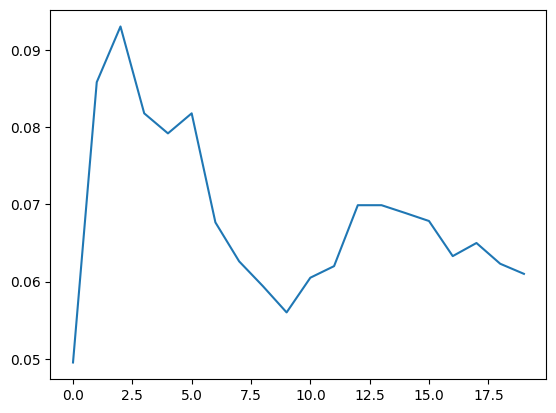

In [6]:
df[df['ticker'] == 'BTC'][:20].high.plot()

In [11]:
btc = df[df['ticker'] == 'BTC']

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(btc.high.values.reshape(-1, 1))
data = data.squeeze()

In [76]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [95]:
data_train = data[:int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

X_train = torch.tensor(np.array([data_train[i:i+20] for i in range(len(data_train)-22)]), dtype=torch.float32)
y_train = torch.tensor(np.array([data_train[i+20:i+22] for i in range(len(data_train)-22)]), dtype=torch.float32)

X_test = torch.tensor(np.array([data_test[i:i+20] for i in range(len(data_test)-22)]), dtype=torch.float32)
y_test = torch.tensor(np.array([data_test[i+20:i+22] for i in range(len(data_test)-22)]), dtype=torch.float32)

In [177]:
data_train = data[:int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

def normalize(iterable):
  top = max(iterable)
  lst = [i/top for i in iterable]
  return lst

data_train_norm = [normalize(data_train[i:i+22]) for i in range(len(data_train)-22)]
data_test_norm = [normalize(data_test[i:i+22]) for i in range(len(data_test)-22)]

X_train = torch.tensor([el[:20] for el in data_train_norm[:-1]], dtype=torch.float32)
y_train = torch.tensor([el[-2:] for el in data_train_norm[:-1]], dtype=torch.float32)

X_test = torch.tensor([el[:20] for el in data_test_norm[:-1]], dtype=torch.float32)
y_test = torch.tensor([el[-2:] for el in data_test_norm[:-1]], dtype=torch.float32)

In [179]:
class NN(nn.Module):
    def __init__(self):
      super(NN, self).__init__()
      self.fc1 = nn.Linear(20, 100)
      self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
      x = self.fc2(F.leaky_relu(self.fc1(x)))
      #x = self.fc2(x)
      return x

In [187]:
model = NN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [181]:
dataloader = DataLoader(X_train, batch_size=32, shuffle=True)
for batch in dataloader:
  print(batch.shape)
  break

torch.Size([32, 20])


In [182]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return len(self.X)

In [183]:
from tqdm import tqdm

In [188]:
epochs = 1000
losses = []

customdataset = CustomDataset(X_train, y_train)
dataloader = DataLoader(customdataset, batch_size=32, shuffle=True)

for ep in tqdm(range(epochs)):
  for batch in dataloader:
    X, y = batch
    yhat = model(X)
    loss = criterion(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss.detach().numpy())
  if ep % 250 == 0:
    print(loss)

  0%|          | 2/1000 [00:00<02:39,  6.24it/s]

tensor(0.0170, grad_fn=<MseLossBackward0>)


 25%|██▌       | 252/1000 [00:44<02:03,  6.06it/s]

tensor(0.0034, grad_fn=<MseLossBackward0>)


 50%|█████     | 502/1000 [01:28<01:20,  6.17it/s]

tensor(0.0118, grad_fn=<MseLossBackward0>)


 75%|███████▌  | 752/1000 [02:12<00:40,  6.07it/s]

tensor(0.0009, grad_fn=<MseLossBackward0>)


100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


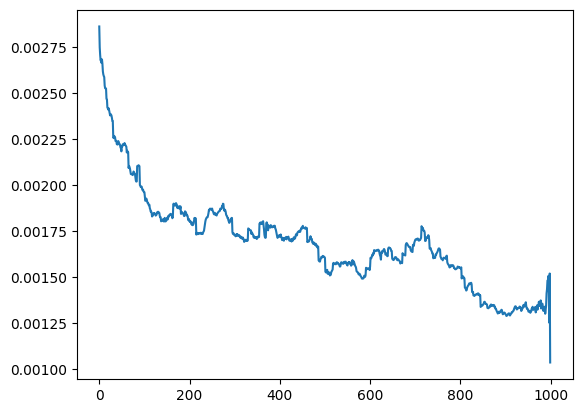

In [189]:
import matplotlib.pyplot as plt
plt.plot([(np.mean(losses[i:i+len(dataloader)])) for i in range(epochs)])
plt.show()

In [190]:
test_customdataset = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test_customdataset, batch_size=32, shuffle=True)
result = []
mae = nn.L1Loss()
test_losses = []

with torch.no_grad():
  for batch in dataloader:
    X, y = batch
    yhat = model(X)
    result.append(mae(yhat, y).item())
    loss = criterion(yhat, y)
    test_losses.append(loss.detach().numpy())

In [191]:
sum(result)/len(result), np.mean(test_losses)

(0.024781904872933417, 0.0013454432)

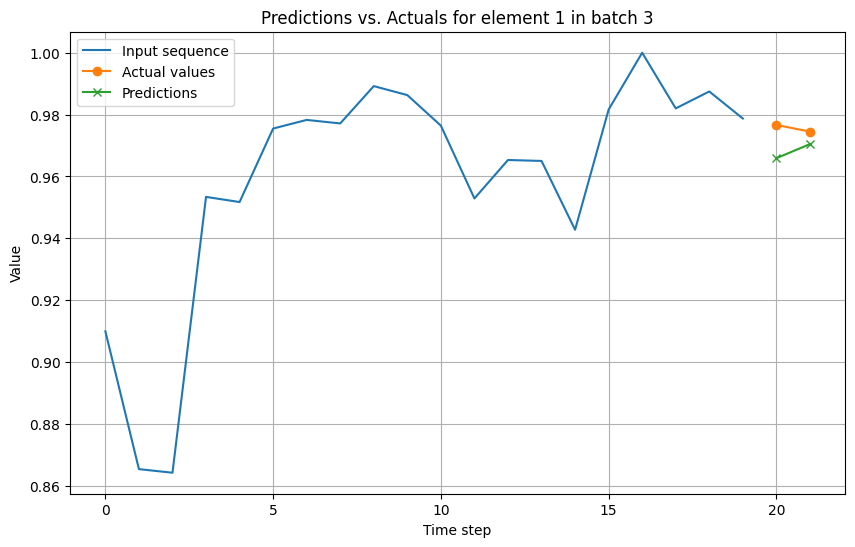

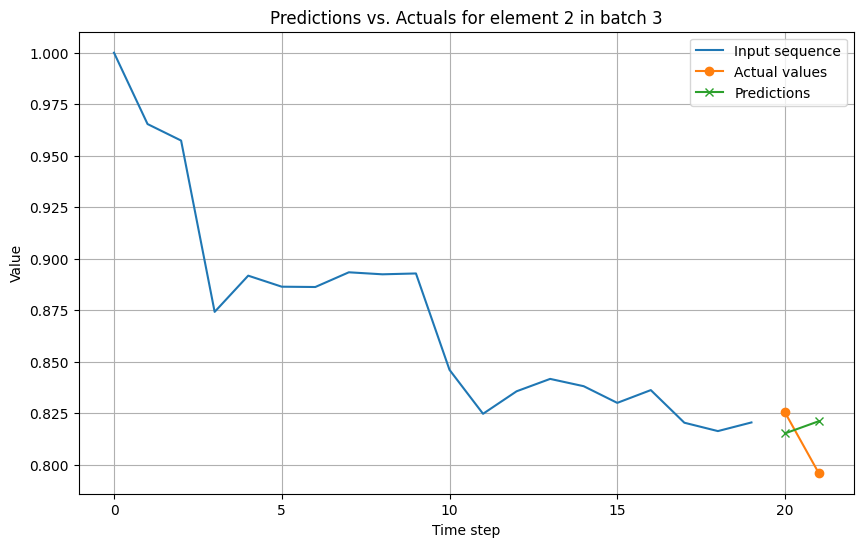

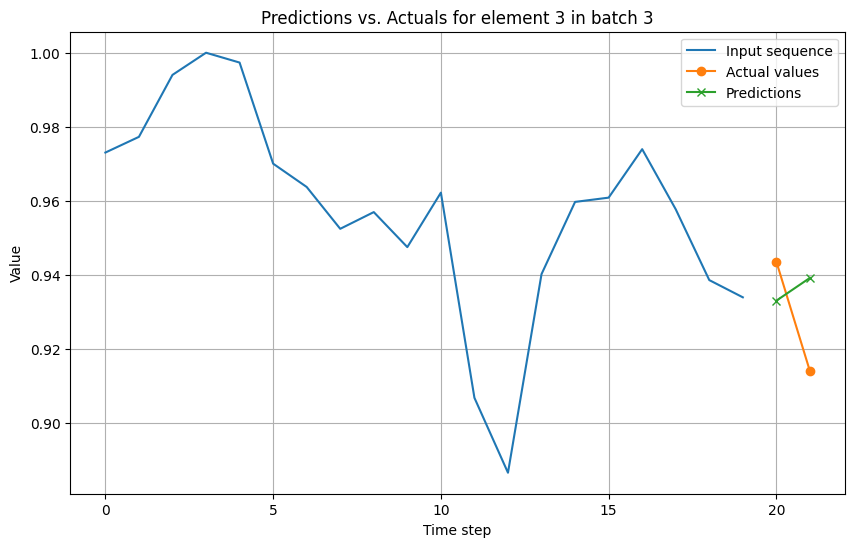

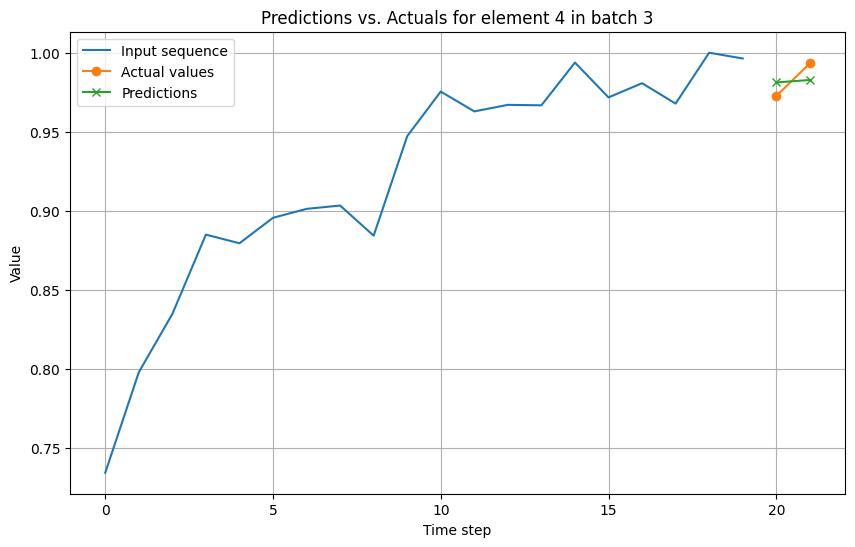

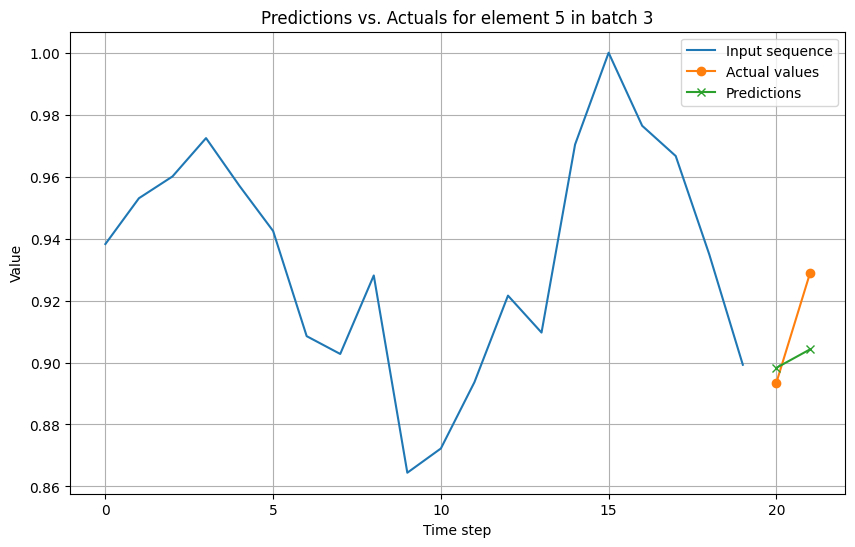

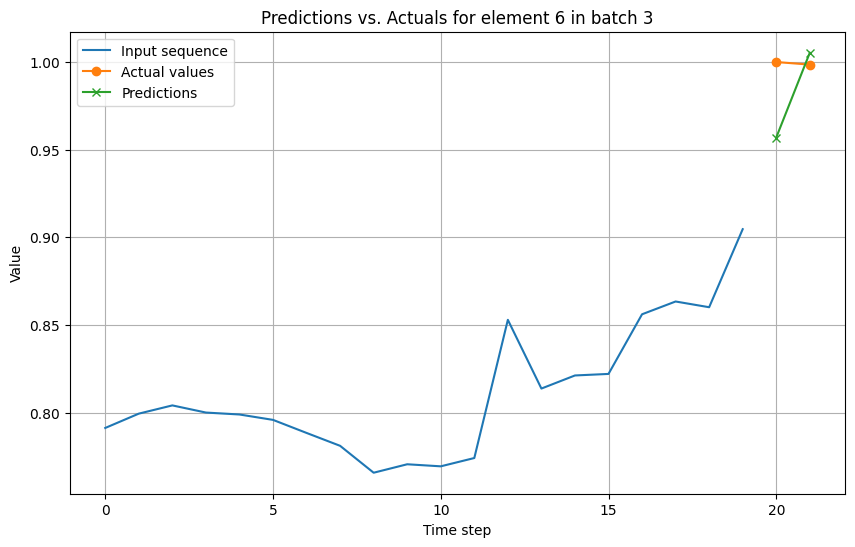

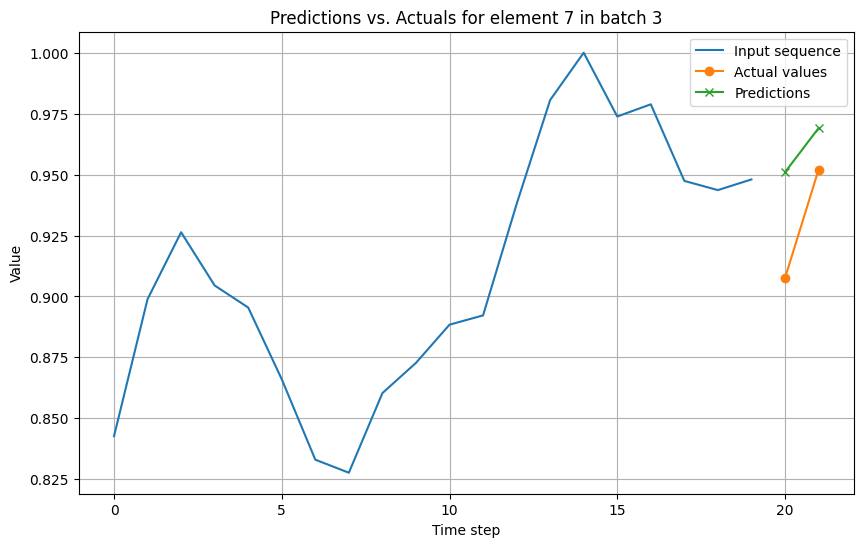

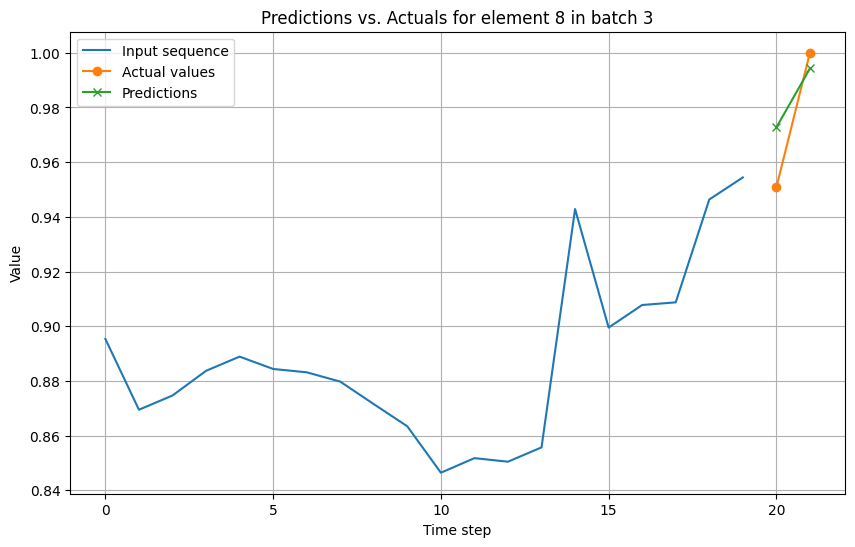

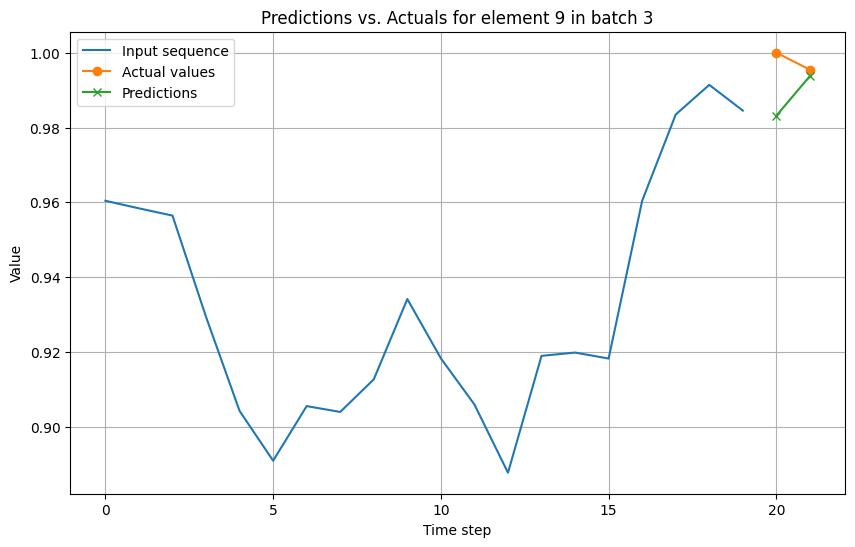

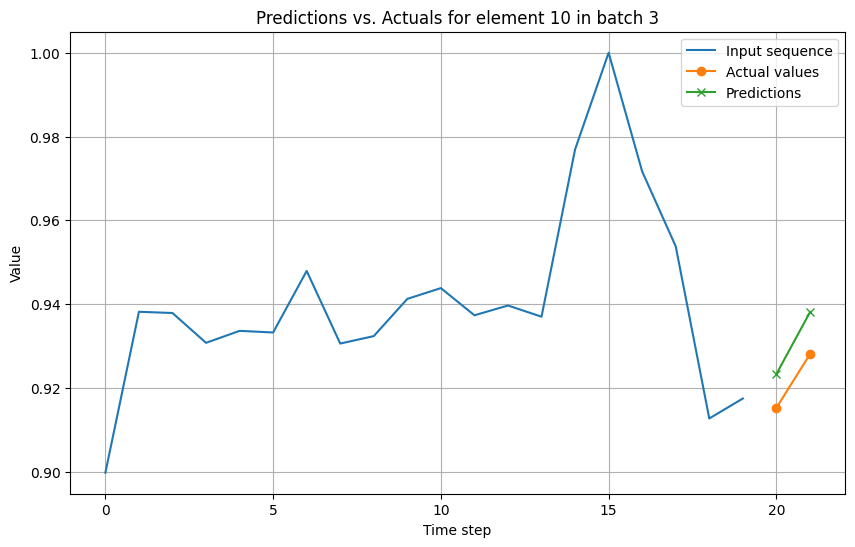

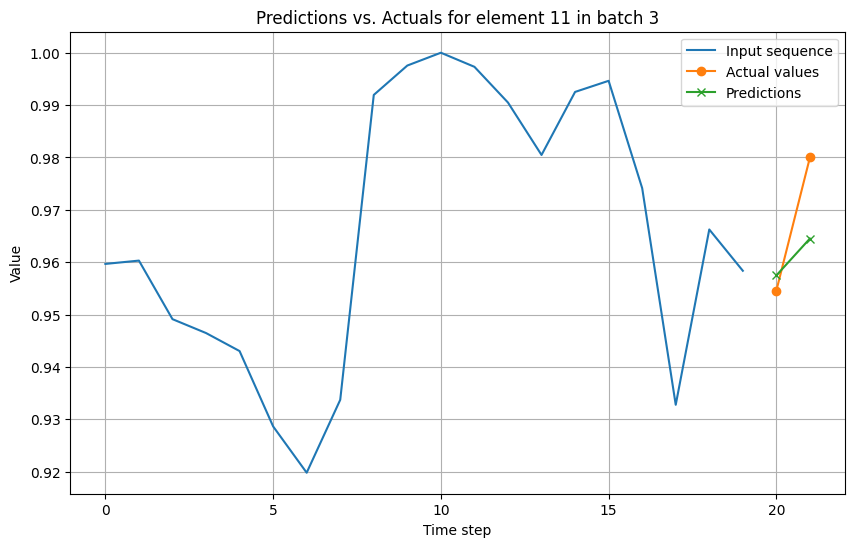

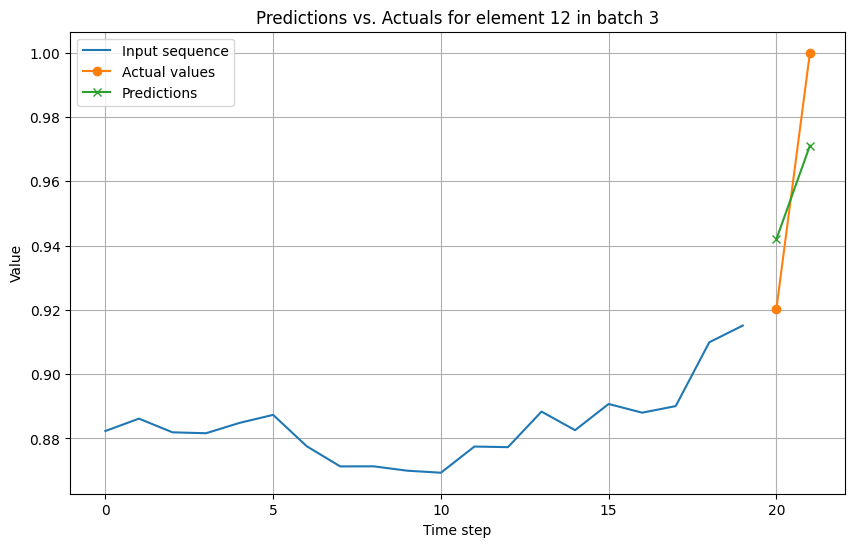

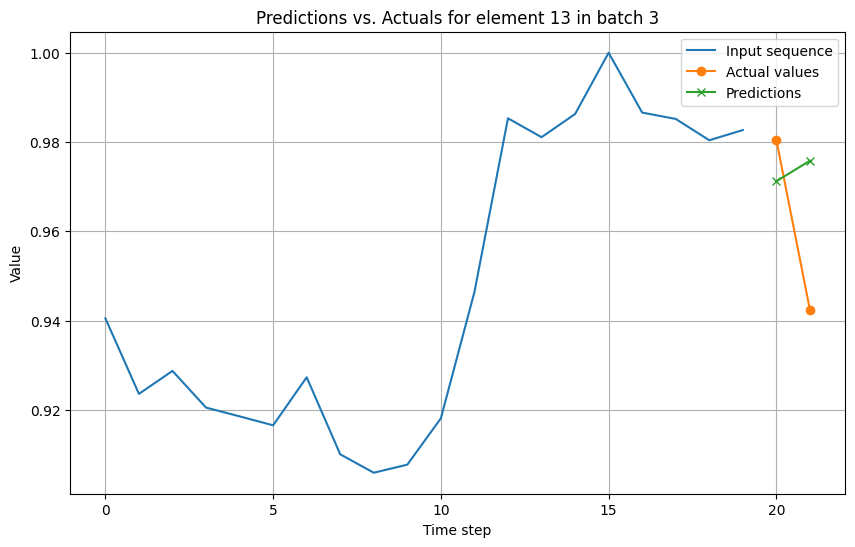

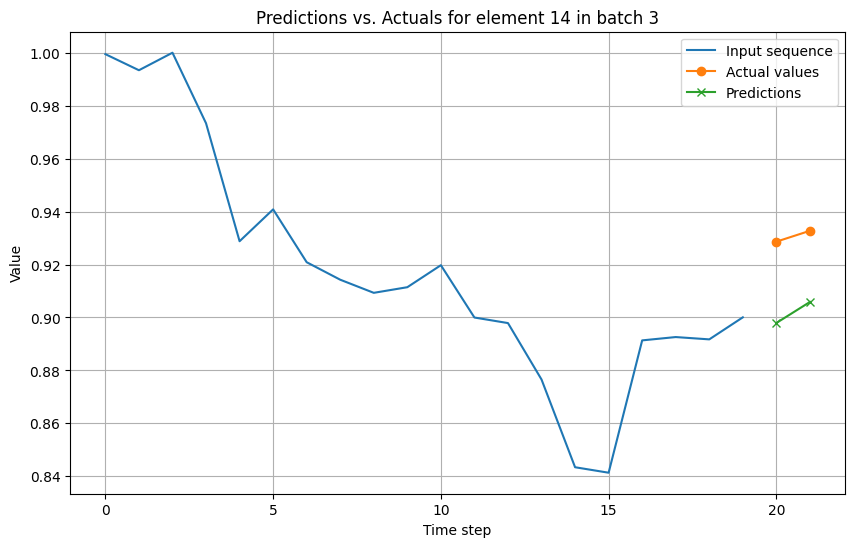

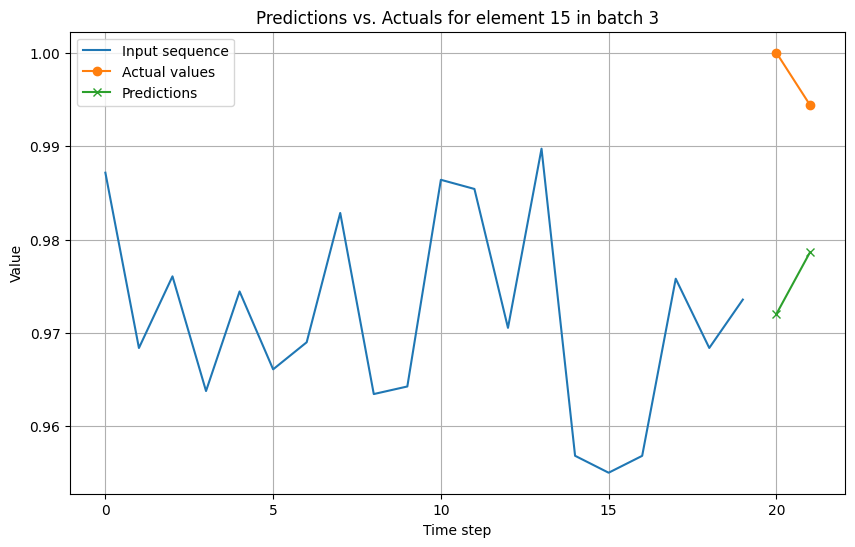

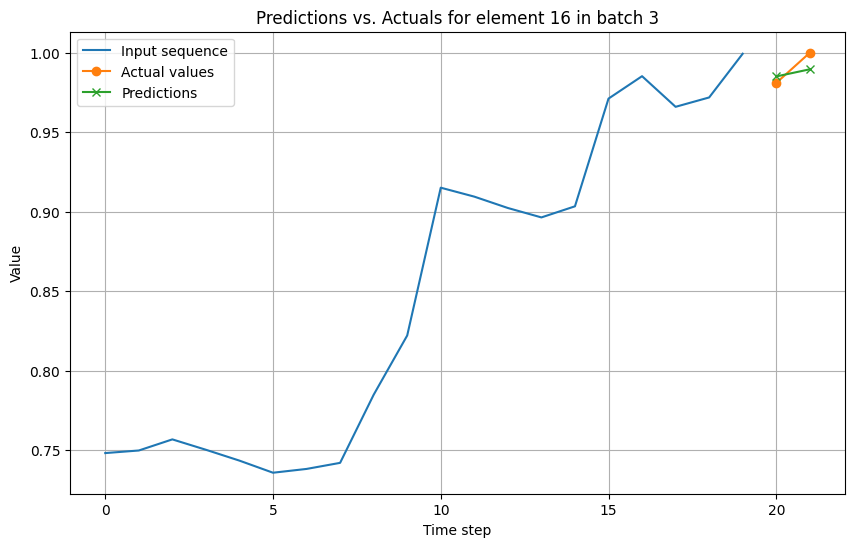

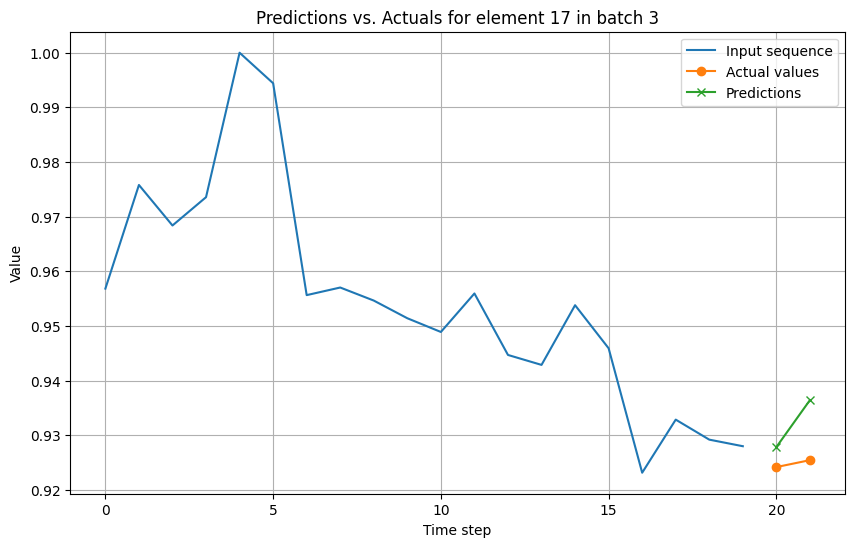

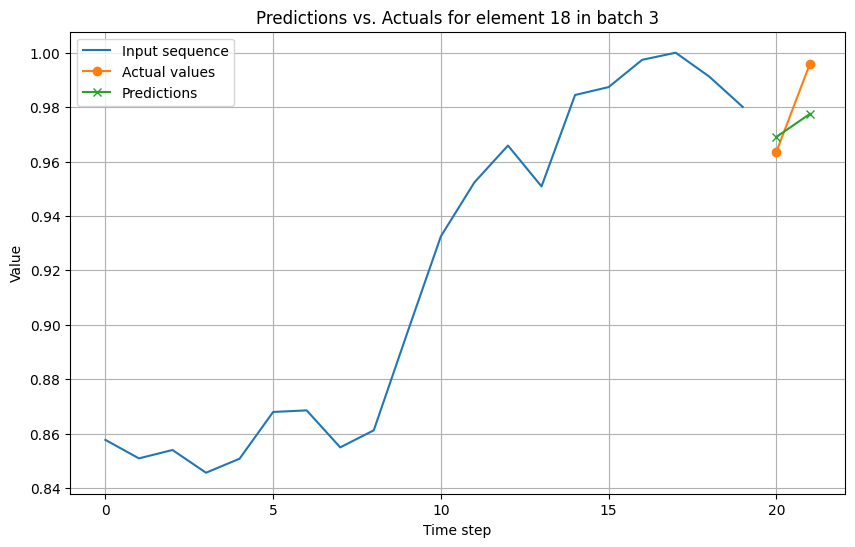

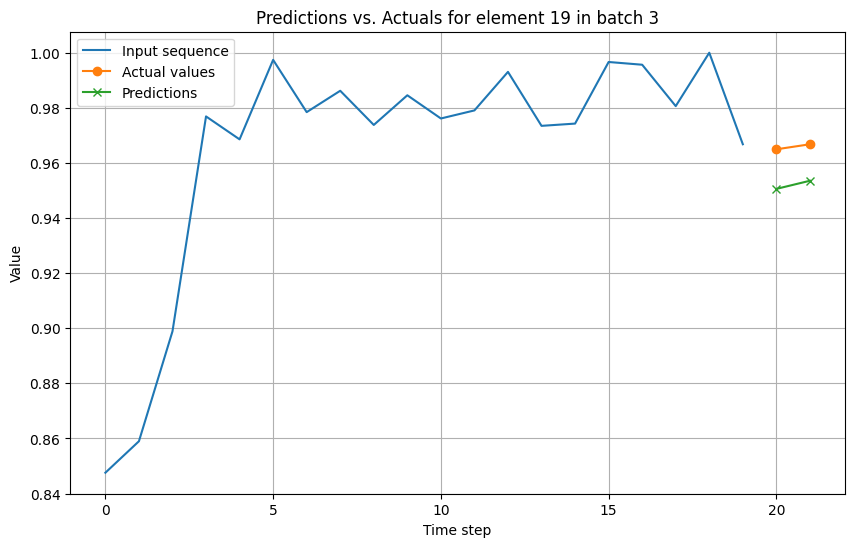

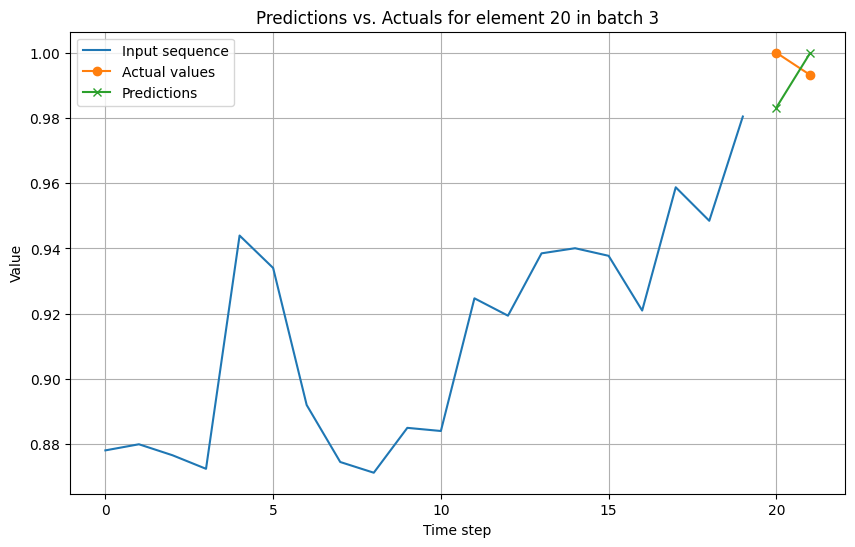

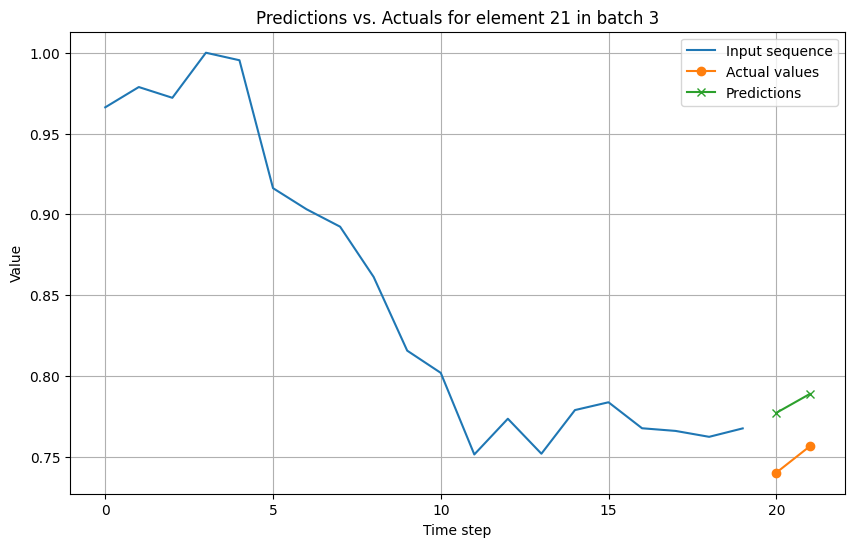

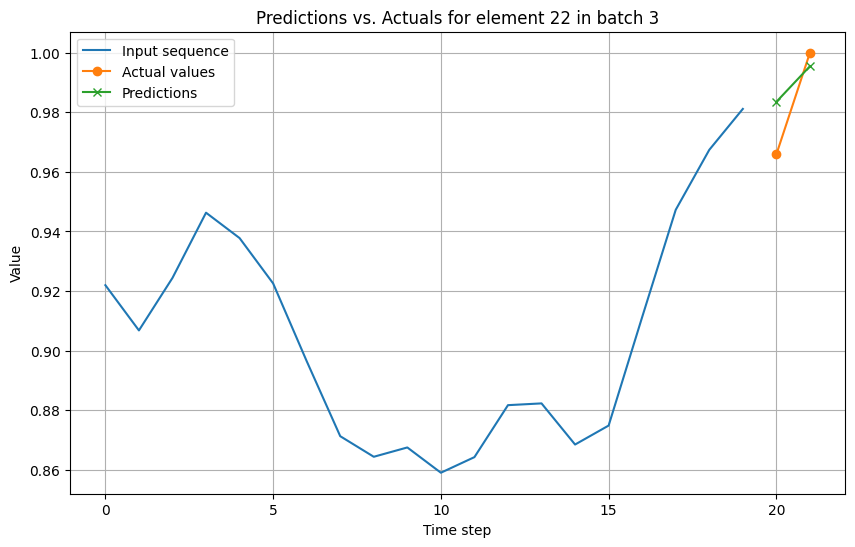

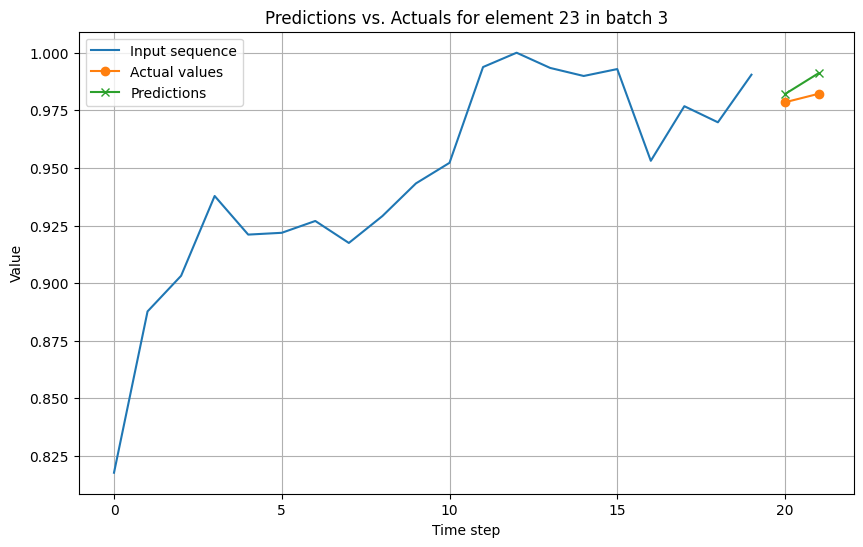

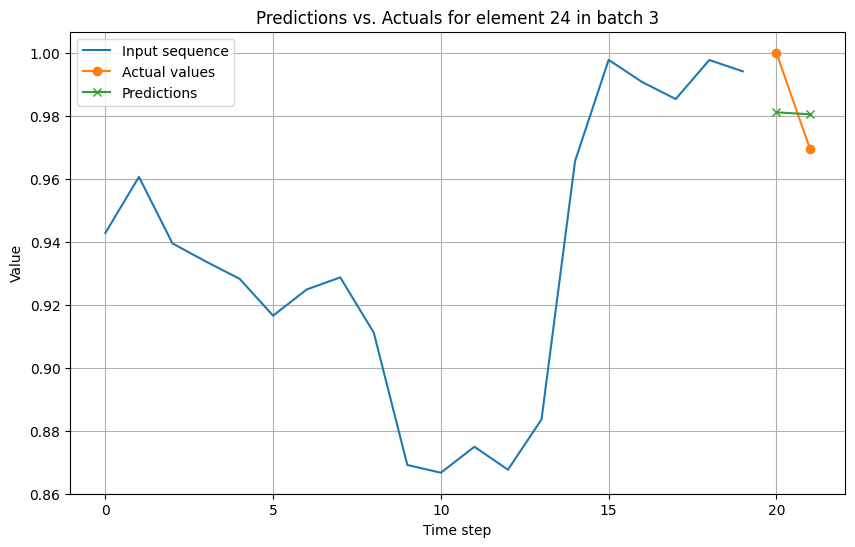

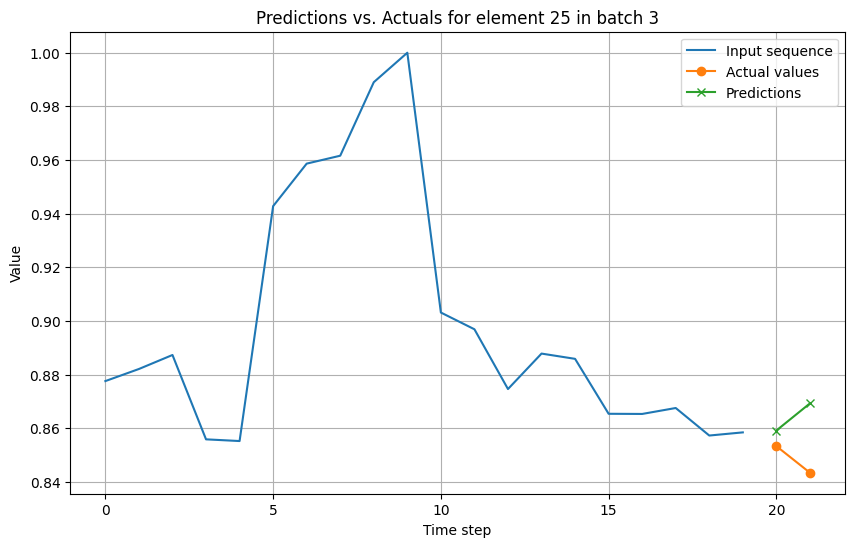

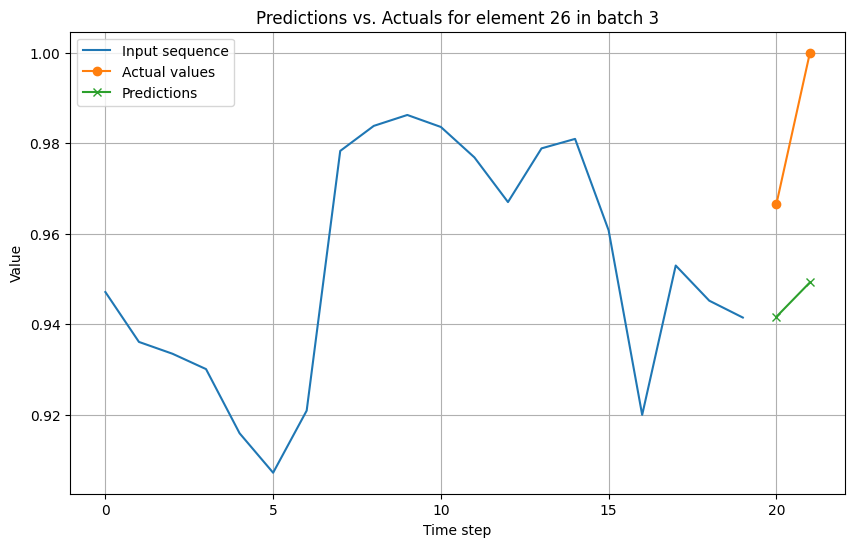

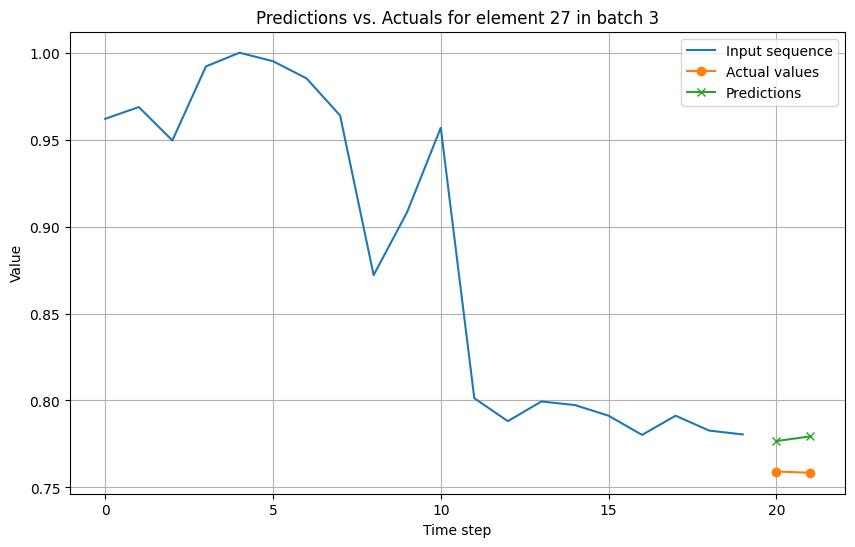

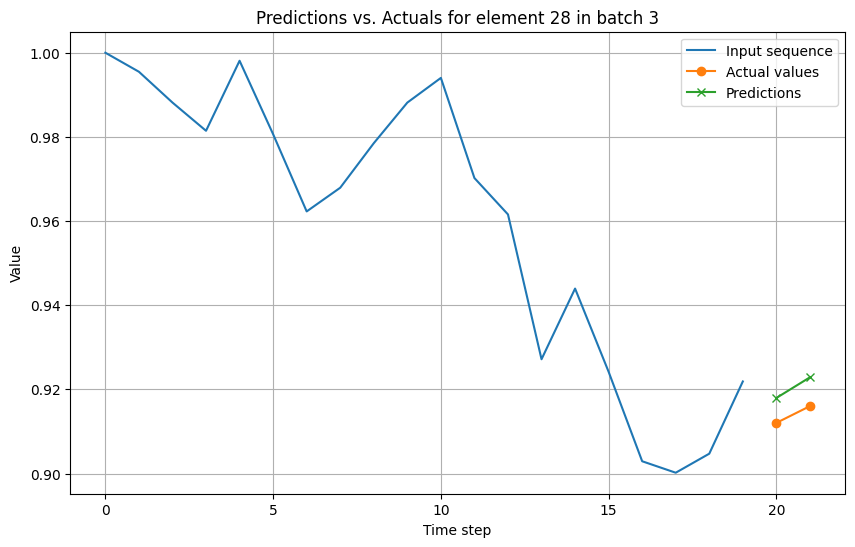

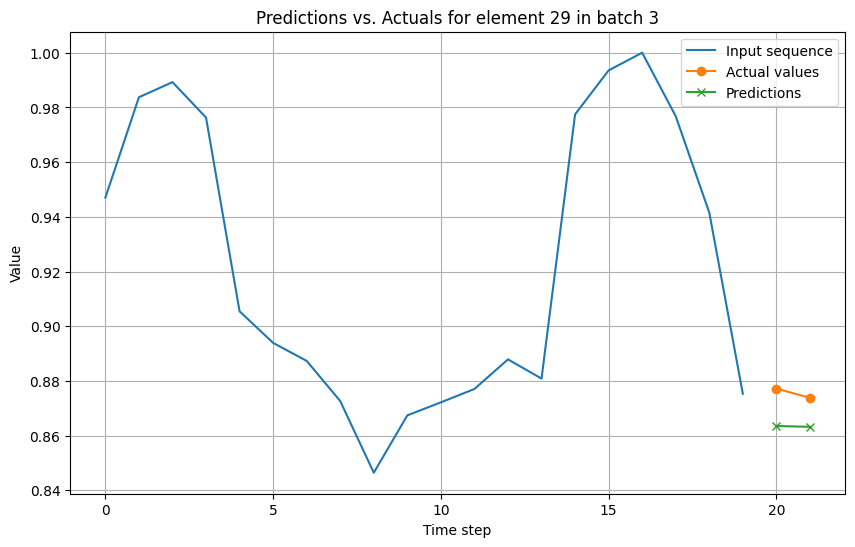

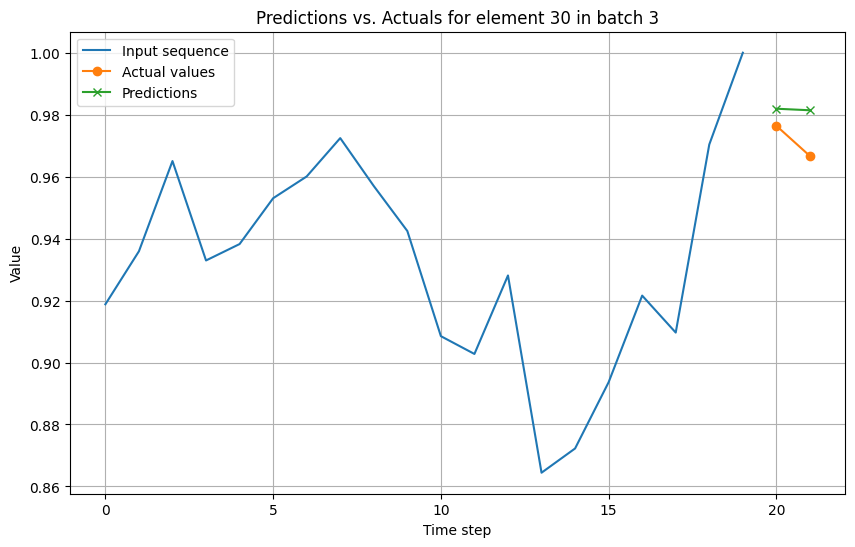

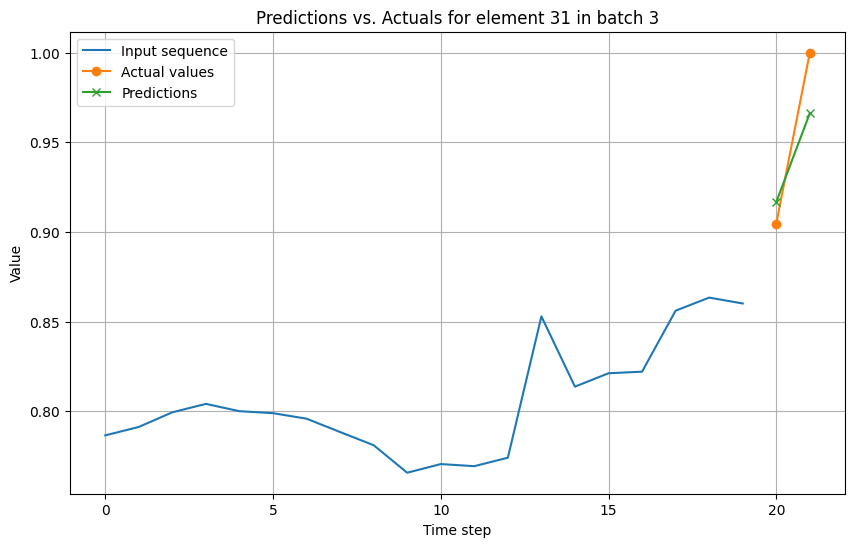

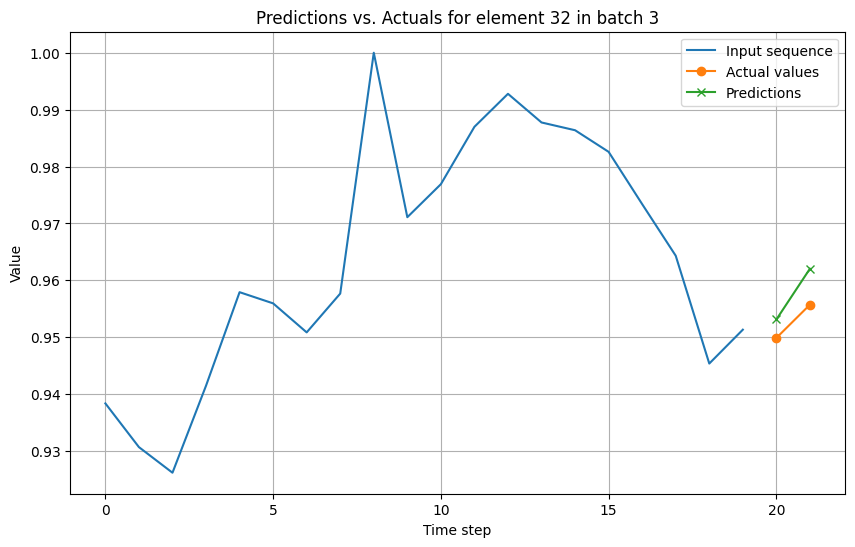

In [192]:
# prompt: i will give you test dataloader and randomly sample one batch and plot predictions for each batch element using plotlib

import random

# Assuming 'test_dataloader' and 'model' are defined as in the previous code.
# ... (Previous code)

# Randomly sample one batch
random_batch_index = random.randint(0, len(test_dataloader) - 1)
for i, batch in enumerate(test_dataloader):
    if i == random_batch_index:
        X, y = batch
        yhat = model(X)
        yhat = yhat.detach()
        break

# Plot predictions for each batch element
for i in range(len(X)):
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    plt.plot(range(20), X[i].numpy(), label='Input sequence')  # Plot the input sequence
    plt.plot(range(20, 22), y[i].numpy(), label='Actual values', marker='o')  # Actual values
    plt.plot(range(20, 22), yhat[i].numpy(), label='Predictions', marker='x') # Predicted values
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'Predictions vs. Actuals for element {i+1} in batch {random_batch_index+1}')
    plt.legend()
    plt.grid(True)
    plt.show()
